In [1]:
# GPLVM training
from mesh_to_sdf import mesh_to_voxels
import trimesh
import numpy as np

obj_names = ['Bus', 'Jeep', 'Pickup', 'Sedan', 'Suv']
voxel_resolution = 64
dct_resolution = 25

def generateAndSaveSdf(obj_name, voxel_resolution):
    mesh = trimesh.load(f'objs2/{obj_name}.obj')
    print(f'Generating {voxel_resolution}x{voxel_resolution}x{voxel_resolution} SDF for {obj_name}...')
    voxels = mesh_to_voxels(mesh, voxel_resolution)
    voxels = np.array(voxels)
    np.save(f'objs2/{obj_name}_SDF_{voxel_resolution}x{voxel_resolution}x{voxel_resolution}', voxels)
    print(f'SDF for {obj_name} generated and saved.')
    return voxels


In [2]:
# # Generate (if not generated yet)
# for obj_name in obj_names:
#     generateAndSaveSdf(obj_name, voxel_resolution)

Generating 64x64x64 SDF for Bus...
SDF for Bus generated and saved.
Generating 64x64x64 SDF for Jeep...
SDF for Jeep generated and saved.
Generating 64x64x64 SDF for Pickup...
SDF for Pickup generated and saved.
Generating 64x64x64 SDF for Sedan...
SDF for Sedan generated and saved.
Generating 64x64x64 SDF for Suv...
SDF for Suv generated and saved.


In [2]:
# Load from generated & saved SDF
sdfs = []
for obj_name in obj_names:
    sdfs.append(np.load(f'objs2/{obj_name}_SDF_{voxel_resolution}x{voxel_resolution}x{voxel_resolution}.npy'))
sdfs = np.array(sdfs)
sdfs.shape

(5, 64, 64, 64)

In [3]:
# 3D DCT
# 3D DCT function
import numpy as np
from scipy.fftpack import dct, idct

def dctn(x, norm="ortho"):
    for i in range(x.ndim):
        x = dct(x, axis=i, norm=norm)
    return x

def idctn(x, norm="ortho"):
    for i in range(x.ndim):
        x = idct(x, axis=i, norm=norm)
    return x

# 3D DCT the voxels
dct_trimmeds = []
for sdf in sdfs:
    dct_full = dctn(sdf)
    dct_trimmeds.append(dct_full[:dct_resolution, :dct_resolution, :dct_resolution])

In [4]:
# GPLVM Training
from mygplvm import MyGPLVM

gplvm = MyGPLVM()
dct_flatteneds = []
for dct_trimmed in dct_trimmeds:
    dct_flatteneds.append(dct_trimmed.flatten())
gplvm.simple_gplvm(dct_flatteneds, 'vehicle_models', latent_dimension = 2, epsilon = 0.001, maxiter = 50)

         Current function value: 92231.596252
         Iterations: 3
         Function evaluations: 782
         Gradient evaluations: 55
time: 0.1994030475616455
alpha 1.1728706633905541
beta 0.6048697071083007
gamma 0.9999992562862754


c:\ProgramData\anaconda3\envs\python310\lib\site-packages\scipy\optimize\_optimize.py:1698: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(f, x0, args, fprime, callback=callback, **opts)


array([[ 51.15094757,   7.46380711],
       [-42.88325882,  12.87237549],
       [ 13.78208447,  -2.41261625],
       [-13.68171972, -10.0678005 ],
       [ -8.36767584,  -7.85580638]])

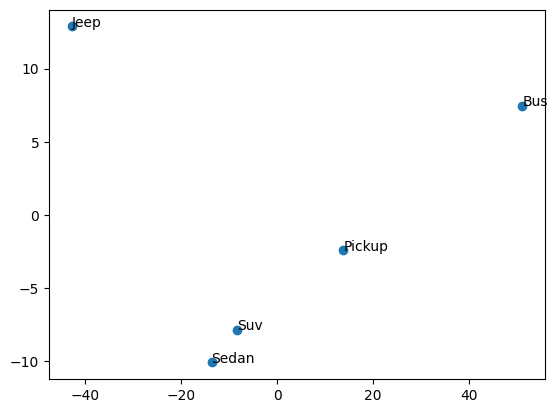

In [5]:
import matplotlib.pyplot as plt

# Scatter plot latent variable
fig, ax = plt.subplots()
ax.scatter(gplvm.X[:, 0], gplvm.X[:, 1])

for i, txt in enumerate(obj_names):
    ax.annotate(txt, (gplvm.X[i, 0], gplvm.X[i, 1]))

In [8]:
import skimage

dct_25_flat = gplvm.recall([-42.88325882,  12.87237549])
dct_25 = np.array(dct_25_flat).reshape((dct_resolution, dct_resolution, dct_resolution))
dct_full = np.pad(dct_25, ((0, voxel_resolution - dct_resolution + 2), (0, voxel_resolution - dct_resolution + 2), (0, voxel_resolution - dct_resolution + 2)))
print(dct_full.shape)

voxels_idct = idctn(dct_full)
voxels_idct = np.pad(voxels_idct, ((1, 1), (1, 1), (1, 1)), constant_values=(1, 1))
mc_vertices, mc_faces, mc_normals, _ = skimage.measure.marching_cubes(voxels_idct, level=0)
mc_mesh = trimesh.Trimesh(vertices=mc_vertices, faces=mc_faces, normals=mc_normals)
mc_mesh.apply_translation([-((voxel_resolution - 4)//2), -((voxel_resolution - 4)//2), -((voxel_resolution - 4)//2)])
mc_mesh.show()

(66, 66, 66)


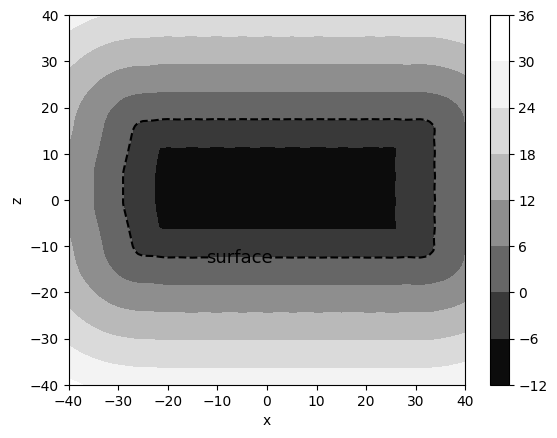

In [49]:
import pytorch_volumetric as pv
import pytorch_kinematics as pk
import torch
from myoptimization2 import MyOptimization2
mo2 = MyOptimization2()
sdf = mo2.reconstruct(gplvm, [-42.88325882,  12.87237549], dct_resolution, voxel_resolution)
# tsf = pk.RotateAxisAngle(90, axis='x')
# tsf = pk.Translate(x = 0, y = 0, z = 0)
# tsf = pk.Scale()
tsf = pk.Transform3d(matrix=torch.asarray([
    [1.0, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
]))
sdf = pv.ComposedSDF([sdf, sdf], tsf.stack(tsf))

query_range = np.array([
            [-40, 40],
            [0, 0],
            [-40, 40],
        ])
result = pv.draw_sdf_slice(sdf, query_range, resolution=0.3125)

In [60]:
result[1]

tensor([[-0.4487,  0.0962, -0.8885],
        [-0.4528,  0.0970, -0.8863],
        [-0.4568,  0.0979, -0.8841],
        ...,
        [ 0.2828,  0.0430,  0.9582],
        [ 0.2829,  0.0424,  0.9582],
        [ 0.2829,  0.0419,  0.9582]])

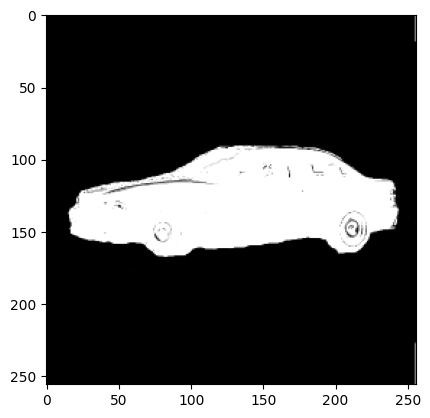

In [80]:
from PIL import Image, ImageOps
import cv2
import math
from math import sin, cos
import numpy as np


def make_square(img):
        resized = cv2.resize(img, (256, 256))
        return resized
        

# def make_square(im, min_size=256, fill_color=(0, 0, 0, 0)):
#     x, y = im.size
#     size = max(min_size, x, y)
#     new_im = Image.new('RGBA', (size, size), fill_color)
#     new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
#     return new_im

def reconstruct(self, gplvm, latent_init, dct_resolution, voxel_resolution, num_iter = 10):
        dct_25_flat = gplvm.recall(latent_init)
        dct_25 = np.array(dct_25_flat).reshape((dct_resolution, dct_resolution, dct_resolution))
        dct_full = np.pad(dct_25, ((0, voxel_resolution - dct_resolution), (0, voxel_resolution - dct_resolution), (0, voxel_resolution - dct_resolution)))
        voxels_idct = idctn(dct_full)
        voxels_idct = np.pad(voxels_idct, ((1, 1), (1, 1), (1, 1)), constant_values=(1, 1))
        
        mc_vertices, mc_faces, mc_normals, _ = skimage.measure.marching_cubes(voxels_idct, level=0)
        mc_mesh = trimesh.Trimesh(vertices=mc_vertices, faces=mc_faces, normals=mc_normals)
        mc_mesh.apply_translation([-((voxel_resolution - 4)//2), -((voxel_resolution - 4)//2), -((voxel_resolution - 4)//2)])

        # convert to open3d
        o3d_mesh = mc_mesh.as_open3d

        # convert to sdf
        obj = pv.MeshObjectFactory(mesh=o3d_mesh)
        sdf = pv.MeshSDF(obj)

        zeta_smoothing = 0.75
        fu = 512
        fv = 512
        
        lambdas = [0. for i in range(7)]    # Tx, Ty, Tz, Rx, Ry, Rz, S; all rotation in degree
        li_mapping = {
             'Tx': 0,
             'Ty': 1,
             'Tz': 2,
             'Rx': 3,
             'Ry': 4,
             'Rz': 5,
             'S': 6
        }
        lambdas[li_mapping['S']] = 1    # set scale to 1
        for n in range(num_iter):
            dE_dlis = [0 for i in range(len(lambdas))]
            Tx = lambdas[li_mapping['Tx']]
            Ty = lambdas[li_mapping['Ty']]
            Tz = lambdas[li_mapping['Tz']]
            Rx = math.radians(lambdas[li_mapping['Rx']])
            Ry = math.radians(lambdas[li_mapping['Ry']])
            Rz = math.radians(lambdas[li_mapping['Rz']])
            S = lambdas[li_mapping['S']]

            M = np.matrix([
                [S*cos(Ry)*cos(Rz)                              , -S*cos(Ry)*sin(Rz)                            , S*sin(Ry)         , Tx],
                [S*cos(Rx)*sin(Rz) + S*sin(Rx)*sin(Ry)*cos(Rz)  , S*cos(Rx)*cos(Rz) - S*sin(Rx)*sin(Ry)*sin(Rz) , -S*sin(Rx)*cos(Ry), Ty],
                [S*sin(Rx)*sin(Rz) - S*cos(Rx)*sin(Ry)*cos(Rz)  , S*sin(Rx)*cos(Rz) + S*cos(Rx)*sin(Ry)*sin(Rz) , S*cos(Rx)*cos(Ry) , Tz],
                [0                                              , 0                                             , 0                 , 1]
            ])
            MI = M.I
            for u in range(256):
                for v in range(256):
                    rf_min_rb = 2 * input_image[u][v] - 1
                    # for i in range(len(lambdas)):
                    # lambda_i = lambdas[i]
                    dEx_dli = 0
                    query_range = np.array([
                        [-40, 40],
                        [-40 + (80/256) * v, -40 + (80/256) * v],
                        [-40, 40],
                    ])
                    coords, pts = pv.get_coordinates_and_points_in_grid(80 / 256, query_range)
                    sdf_val, sdf_grad = sdf(pts)

                    x = (u - 128) / 256
                    y = (128 - 0) / 256
                    for l in range(256):
                        z = (l - 128) / 256
                        [x0, y0, z0, w] = np.array(MI * np.matrix([x, y, z, 1]).T).flatten()

                        phi_l = sdf_val[u + 257 * l]
                        exp_phi_l_zeta = math.exp(phi_l * zeta_smoothing)

                        dl_dx = sdf_grad[u + 257 * l][0]
                        dl_dy = sdf_grad[u + 257 * l][1]
                        dl_dz = sdf_grad[u + 257 * l][2]

                        dx_dli = [
                             1,
                             0,
                             0,
                             0,
                             -x0*S*sin(Ry)*cos(Rz) + y0*S*sin(Ry)*sin(Rz) + z0*S*cos(Ry),
                             -x0*S*cos(Ry)*sin(Rz) - y0*S*cos(Ry)*cos(Rz),
                             x0*cos(Ry)*cos(Rz) - y0*cos(Ry)*sin(Rz) + z0*sin(Ry)
                        ]
                        dy_dli = [
                             0,
                             1,
                             0,
                             x0*S*(-sin(Rx)*sin(Rz) + cos(Rx)*sin(Ry)*cos(Rz)) + y0*S*(-sin(Rx)*cos(Rz) - cos(Rx)*sin(Ry)*sin(Rz)) - z0*S*cos(Rx)*cos(Ry),
                             
                        ]

                        dx_dTx = 1
                        dx_dTy = 0
                        dx_dTz = 0

                        dy_dTy = 0
                        dy_dTy = 1
                        dy_dTz = 0

                        dy_
                        
                        dl_dli = 0
                    

                        dEx_dli += (exp_phi_l_zeta / (exp_phi_l_zeta + 1)) * dl_dli


                        dEx_dli *= rf_min_rb * -1
                        dE_dlis[i] += dEx_dli
                        

        
input_image = cv2.imread('input_images/sedan1.png', cv2.IMREAD_GRAYSCALE)
input_image = make_square(input_image)
input_image = (255 - input_image) / 255
plt.imshow(input_image, cmap='gray')